In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
all_assets = pd.read_excel("etf_combined.xlsx", index_col="Date", parse_dates=["Date"]).dropna()
asset_rets = all_assets.pct_change().dropna()
optimal_portfolio_weights = pd.read_excel("../../results/selected_assets_summary.xlsx", parse_dates=False).set_index("Ticker")["Weight"]
benchmark_df = pd.read_excel("../raw/benchmarks/ftse_balance_prices.xlsx", parse_dates=["Date"], index_col="Date")


In [22]:
common = asset_rets.columns.intersection(optimal_portfolio_weights.index)

missing = set(optimal_portfolio_weights.index) - set(common)
if missing:
    raise KeyError(f"No returns for tickers: {missing}")

asset_rets = asset_rets[common]

weights = optimal_portfolio_weights.loc[common]

# Compute your portfolio’s daily return series
optimal_portfolio_returns = asset_rets.dot(weights.values)
optimal_portfolio_returns.name = "Portfolio"

print(optimal_portfolio_returns.head())

# Figure out the “3 years ago” cut-off
end = optimal_portfolio_returns.index.max()
start = end - pd.DateOffset(years=3)
# Slice by label
port_last3 = optimal_portfolio_returns.loc[start:end]
# ---
out = port_last3.to_frame(name="PortfolioReturn")
out.to_excel("../../results/portfolio_returns_last3y.xlsx", index=True)
print(f"Saved {len(out)} daily returns to portfolio_returns_last3y.xlsx")

Date
2022-06-14   -0.001134
2022-06-15    0.001874
2022-06-16   -0.017347
2022-06-17    0.005899
2022-06-21    0.006083
Name: Portfolio, dtype: float64
Saved 670 daily returns to portfolio_returns_last3y.xlsx


In [23]:
# Now the benchmark
benchmark_df.columns = benchmark_df.columns.str.strip()

benchmark_df.index = pd.to_datetime(benchmark_df.index)
benchmark_df = benchmark_df.sort_index(ascending=True)

print("Benchmark columns:", benchmark_df.columns.tolist())

benchmark_returns = benchmark_df["Last Price"].pct_change().dropna().rename("Benchmark")

df = pd.concat([benchmark_returns, optimal_portfolio_returns], axis=1).dropna()
df.head()

Benchmark columns: ['Last Price']


/var/folders/k0/9514c2kj447cm58pbj7ncbpw0000gn/T/ipykernel_4155/2107924918.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  benchmark_returns = benchmark_df["Last Price"].pct_change().dropna().rename("Benchmark")


,Benchmark,Portfolio
Date,,
2022-06-14,0.000271,-0.001134
2022-06-15,0.005393,0.001874
2022-06-16,-0.023073,-0.017347
2022-06-17,0.002829,0.005899
2022-06-21,0.007253,0.006083


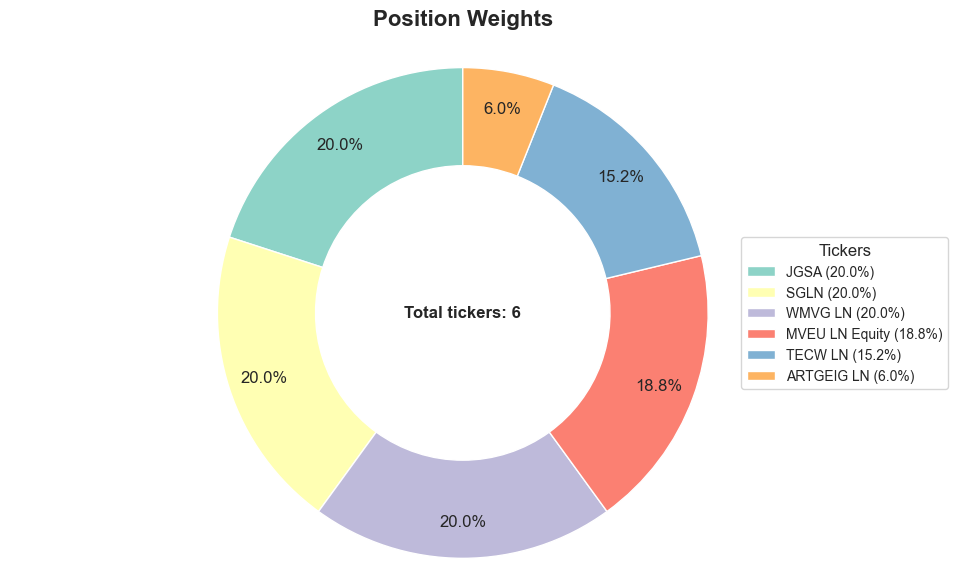

In [24]:
position_weights = optimal_portfolio_weights
# Create figure
plt.figure(figsize=(10, 6))

# Create donut chart
wedges, texts, autotexts = plt.pie(
    position_weights.values,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops=dict(width=0.4),
    pctdistance=0.85,
    colors=plt.cm.Set3(range(len(position_weights)))
)

# Add center text
total_tickers = len(position_weights)
coverage = 100.0  # Since we're showing all positions

plt.text(0, 0, f'Total tickers: {total_tickers}', 
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=12,
         fontweight='bold')

# Create legend
legend_labels = [f'{ticker} ({weight*100:.1f}%)' 
                for ticker, weight in position_weights.items()]

plt.legend(wedges, legend_labels, 
           title="Tickers", 
           loc="center left", 
           bbox_to_anchor=(0.8, 0, 0.8, 1),
           fontsize=10)

plt.title('Position Weights', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.savefig("../../results/position_weights.png", dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

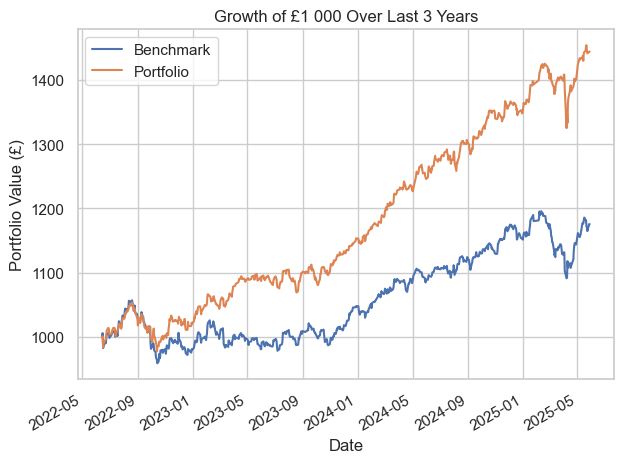

Today you would have:  Portfolio = £1,443.94
                       Benchmark = £1,175.49


In [25]:
initial_capital = 1000.0

# Compute cumulative value series
value = (1 + df).cumprod() * initial_capital

# Plot
plt.figure()
value.plot()              
plt.title("Growth of £1 000 Over Last 3 Years")
plt.ylabel("Portfolio Value (£)")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("../../results/growth_last3years.png", dpi=300)
plt.show()

# Print final values
final_port = value["Portfolio"].iloc[-1]
final_bench= value["Benchmark"].iloc[-1]
print(f"Today you would have:  Portfolio = £{final_port:,.2f}")
print(f"                       Benchmark = £{final_bench:,.2f}")



In [26]:
risk_free_rate = 0.0444
annual_factor  = 252

# 2) Compute statistics
# ---------------------
stats = pd.DataFrame(index=['Portfolio','Benchmark'])

# Daily stats
stats['Mean Daily']    = df.mean()
stats['Vol Daily']     = df.std()
stats['Var Daily']     = df.var()

# Annualised stats
stats['Mean Ann']      = stats['Mean Daily'] * annual_factor
stats['Vol Ann']       = stats['Vol Daily'] * np.sqrt(annual_factor)
stats['Sharpe Ratio']  = (stats['Mean Ann'] - risk_free_rate) / stats['Vol Ann']

# 3) Nicely format and display
# -----------------------------
formatters = {
    'Mean Daily':   '{:.2%}'.format,
    'Vol Daily':    '{:.2%}'.format,
    'Var Daily':    '{:.2%}'.format,
    'Mean Ann':     '{:.2%}'.format,
    'Vol Ann':      '{:.2%}'.format,
    'Sharpe Ratio': '{:.4f}'.format,   # <- absolute number, not percent
}
print("\nBacktest Summary Statistics:\n")

print(stats.to_string(formatters=formatters))

# 4) (Optional) export to Excel
stats.to_excel("../../results/bench_vs_portfolio.xlsx")
print("\nExported summary to bench_vs_portfolio.xlsx")


Backtest Summary Statistics:

          Mean Daily Vol Daily Var Daily Mean Ann Vol Ann Sharpe Ratio
Portfolio      0.06%     0.47%     0.00%   14.16%   7.49%       1.2985
Benchmark      0.03%     0.48%     0.00%    6.40%   7.64%       0.2567

Exported summary to bench_vs_portfolio.xlsx
